In [1]:
import pyccl as ccl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Produce theory $\xi_+$ and $\xi_-$ with one LSST bin

In [2]:
y1 = True

if y1:
    file = 'data/nzdist_y1.txt'
else:
    file = 'data/nzdist.txt'
df = pd.read_csv(file, sep=' ') 
zmid = np.array((df['zmid']))
dneff = np.array(df['dneff'])

In [3]:
cosmo = ccl.Cosmology(Omega_c = 0.2666,
                     Omega_b = 0.049,
                     h = 0.6727,
                     sigma8 = 0.831,
                     n_s = 0.9645,
                     transfer_function = 'eisenstein_hu')
ell = 10**(np.linspace(0,4,500))

In [4]:
lens1 = ccl.WeakLensingTracer(cosmo, dndz=(zmid, dneff))


/global/common/software/lsst/gitlab/desc-python-prod/2024-03-04-26-36/py/lib/python3.10/site-packages/pyccl/tracers.py:151: CCLWarning: The number of samples in the n(z) (40) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False before instantiating the Cosmology passed.
  warnings.warn(


In [5]:
cls = ccl.angular_cl(cosmo, lens1, lens1, ell)

In [6]:
theta_deg = np.logspace(-2, np.log10(5.), 100) # Theta is in degrees

#Cosmic shear:
xi_plus = ccl.correlation(cosmo, ell=ell, C_ell=cls, theta=theta_deg, type='GG+', method='FFTLog')
xi_minus = ccl.correlation(cosmo, ell=ell, C_ell=cls, theta=theta_deg, type='GG-', method='FFTLog')

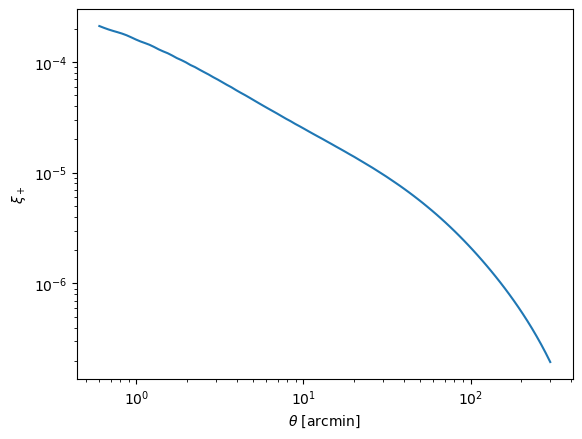

In [7]:
plt.plot(theta_deg*60,xi_plus)
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\xi_+$')

plt.xscale('log')
plt.yscale('log')

## Apply a ratio to $\xi_+$ and turn it into a requirement

In [8]:
total_budget = 0.01
PSF_share = 0.3

In [9]:
total_req = xi_plus * total_budget
psf_req = total_req * PSF_share

(0.5, 200)

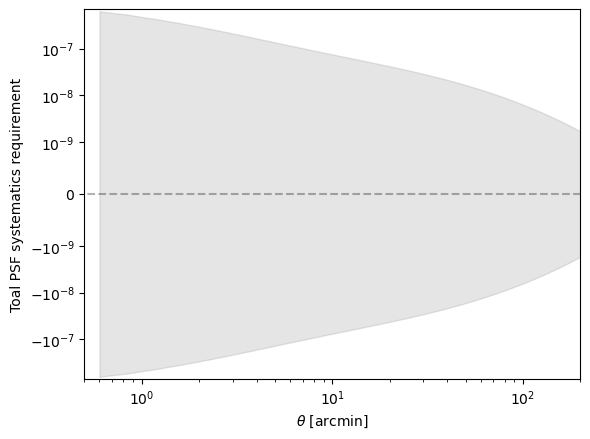

In [10]:
plt.fill_between(theta_deg*60,-psf_req, psf_req, color = 'grey', alpha = 0.2)
plt.plot([0.0, 1000], [0,0], '--', alpha = 0.3, color = 'black')
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'Toal PSF systematics requirement')

plt.xscale('log')
plt.yscale('symlog', linthresh = 1e-9)
plt.xlim(0.5, 200)


(0.5, 200)

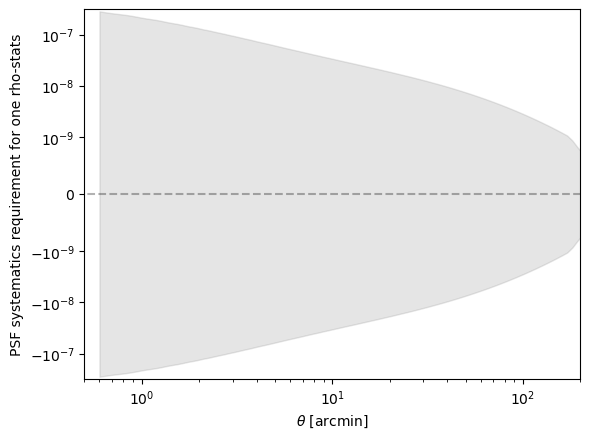

In [11]:
plt.fill_between(theta_deg*60,-psf_req/np.sqrt(5), psf_req/np.sqrt(5), color = 'grey', alpha = 0.2)
plt.plot([0.0, 1000], [0,0], '--', alpha = 0.3, color = 'black')
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'PSF systematics requirement for one rho-stats')

plt.xscale('log')
plt.yscale('symlog', linthresh = 1e-9)
plt.xlim(0.5, 200)


### Setting empirical values for $\alpha$, $\beta$, and $\eta$

In [15]:
leakage_parameters = {
    'des'  : {'alpha' : 0.017, 
              'beta'  : 0.85,
              'eta'   : 7.4,
              },
    'hsc' : {'alpha' : 0.024,
             'beta'  : -0.4,
             'eta'   : 0.,
             },
}

#### artificially set the alphas to 0.01 below:
gaussian_formalism_tratios = {
    'hsc' : {'tratio' : 0.116 / 1,  ##### still needs <T_gal> in denominator
             'dtratio': 0, ##### <dT>/<Tgal>
             'alpha'  : 0.01}, 
    'dc2' : {'tratio' : 0.3702 / 0.8881, 
             'dtratio': 0 / 0.8881, ##### needs <dT>
             'alpha'  : 0.01},
    'des' : {'tratio' : 0.4122 / 0.5971, 
             'dtratio': 0 / 0.5971, ##### needs <dT>
             'alpha'  : 0.01}
}

In [18]:
pre_factor_lists = {}

for source, params in leakage_parameters.items():
    
    pre_factor_rho1 = params['beta'] * params['beta']
    pre_factor_rho2 = params['alpha'] * params['beta']
    pre_factor_rho3 = params['eta'] * params['eta']
    pre_factor_rho4 = params['beta'] * params['eta']
    pre_factor_rho5 = params['alpha'] * params['eta']
    
    pre_factor_lists[source+'_fit'] = [
        pre_factor_rho1, 
        pre_factor_rho2, 
        pre_factor_rho3, 
        pre_factor_rho4, 
        pre_factor_rho5,
        0 # set coefficient on xi_+ term to 0
    ]
    
for source, params in gaussian_formalism_tratios.items():
    
    pre_factor_lists[source+'_ph08'] = [
        params['tratio']**2, 
        -2 * params['tratio'] * params['alpha'], 
        params['tratio']**2, 
        2 * params['tratio']**2, 
        -2 * params['tratio'] * params['alpha'],
        2 * params['dtratio'] 
    ]

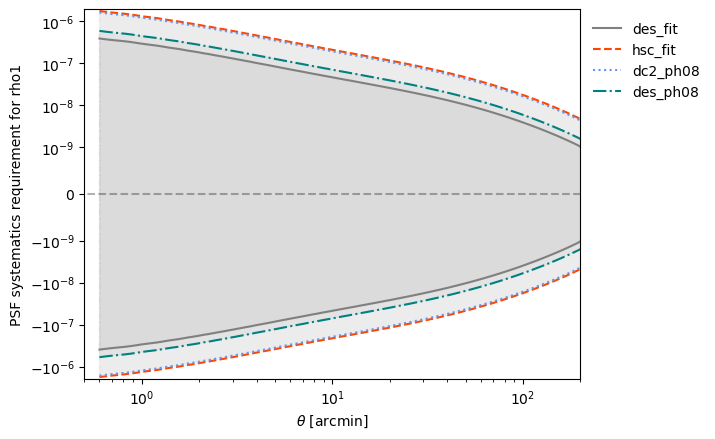

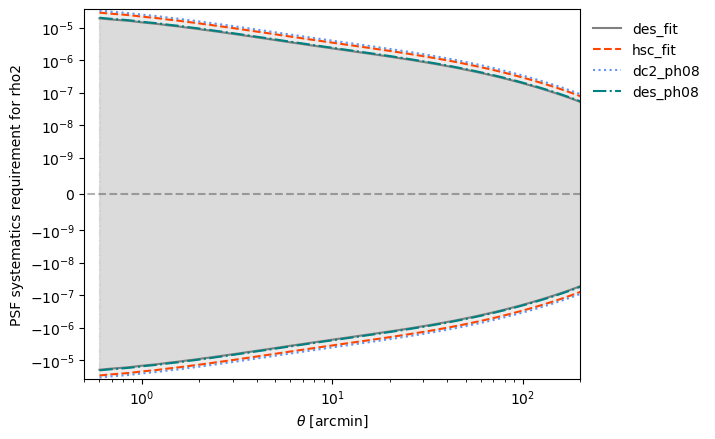

/tmp/ipykernel_154781/4289817946.py:12: RuntimeWarning: divide by zero encountered in divide
  psf_req_rho = psf_req_one/pre_factor_lists[source][i]


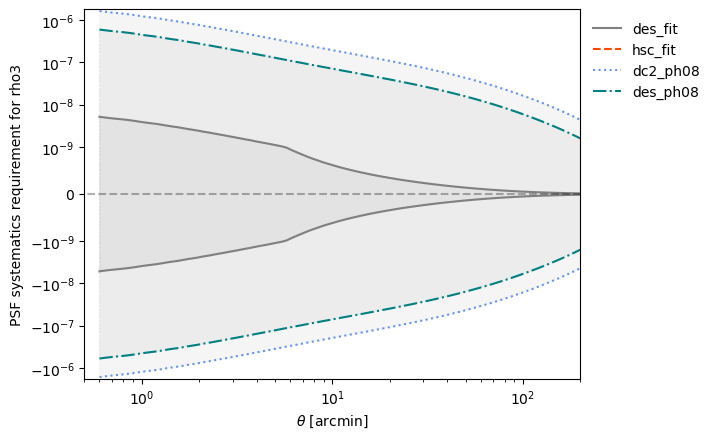

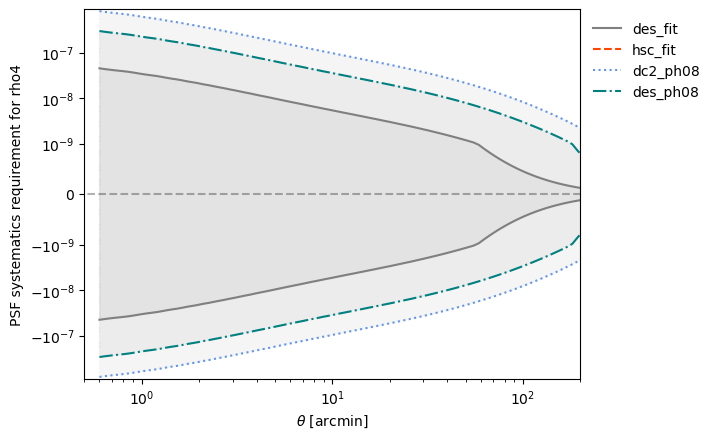

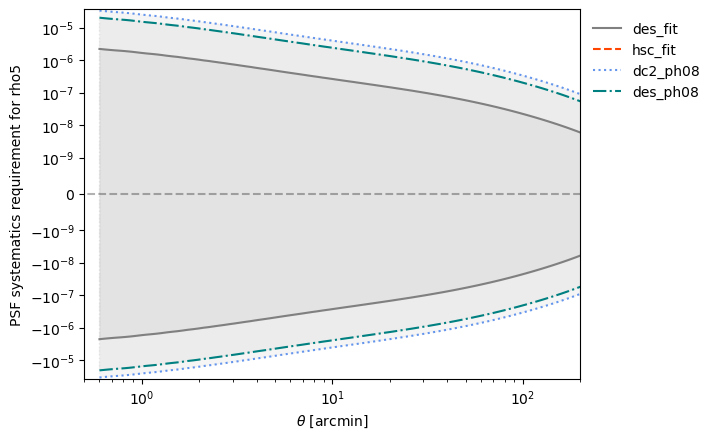

In [19]:
sources_display = ['des_fit', 'hsc_fit', 'dc2_ph08', 'des_ph08']

alpha = 0.3 / len(sources_display)
lines = ['-', '--', ':', '-.', (0, (5, 10))]
colors = ['grey', 'orangered', 'cornflowerblue', 'teal', 'magenta']

for i in range(5):
    
    psf_req_one = psf_req/np.sqrt(5)
    
    for source, ls, c in zip(sources_display, lines, colors):
        psf_req_rho = psf_req_one/pre_factor_lists[source][i]
        plt.fill_between(theta_deg*60, -psf_req_rho, psf_req_rho, color='grey', ls=ls, alpha=alpha)
        plt.plot(theta_deg*60, psf_req_rho, color=c, ls=ls) 
        plt.plot(theta_deg*60, -psf_req_rho, color=c, ls=ls, label=source)
    
    plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))
    plt.plot([0.0, 1000], [0,0], '--', alpha = 0.3, color = 'black')
    plt.xlabel(r'$\theta$ [arcmin]')
    plt.ylabel(f'PSF systematics requirement for rho{i+1}')

    plt.xscale('log')
    plt.yscale('symlog', linthresh = 1e-9)
    plt.xlim(0.5, 200)
    plt.show()
